# Data Profiling - Raw Excel Analysis

This notebook analyzes the raw Excel data BEFORE any pipeline processing.

## Objectives
- Analyze raw data quality and completeness
- Identify data issues and outliers
- Understand data distributions
- Generate insights for pipeline design


In [6]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)


## Load Raw Excel Data

Load the original Excel file to analyze data quality before any processing.


In [7]:
# Load raw Excel data
excel_file = "../data/Data Engineer Challenge.xlsx"

if not Path(excel_file).exists():
    print(f"❌ Error: Excel file not found at {excel_file}")
    print("Please ensure the Excel file is in the data/ directory")
else:
    print(f"📁 Loading raw data from: {excel_file}")
    df = pd.read_excel(excel_file)
    
    print(f"📊 Raw Data Overview:")
    print(f"  Rows: {len(df):,}")
    print(f"  Columns: {df.shape[1]}")
    print(f"  Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


📁 Loading raw data from: ../data/Data Engineer Challenge.xlsx
📊 Raw Data Overview:
  Rows: 100,000
  Columns: 19
  Memory Usage: 53.66 MB


## Data Quality Overview


In [8]:
# Basic data info
print("Raw Data Information:")
print("=" * 50)
print("Data Types:")
print(df.dtypes)
print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# First few rows
print("\nFirst 5 rows:")
print(df.head())


Raw Data Information:
Data Types:
Loan ID                          object
Customer ID                      object
Loan Status                      object
Current Loan Amount               int64
Term                             object
Credit Score                    float64
Annual Income                   float64
Years in current job             object
Home Ownership                   object
Purpose                          object
Monthly Debt                    float64
Years of Credit History         float64
Months since last delinquent    float64
Number of Open Accounts           int64
Number of Credit Problems         int64
Current Credit Balance            int64
Maximum Open Credit             float64
Bankruptcies                    float64
Tax Liens                       float64
dtype: object

Memory Usage: 53.66 MB

First 5 rows:
                                Loan ID                           Customer ID  \
0  14dd8831-6af5-400b-83ec-68e61888a048  981165ec-3274-42f5-a3b4-d104041

## Duplicate Analysis


Duplicate Analysis:
Total Duplicates: 10,215 (10.21%)
Unique Records: 89,785


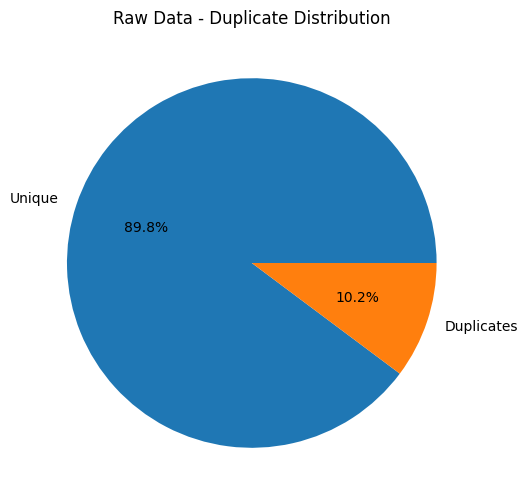

In [9]:
# Duplicate analysis
duplicates = df.duplicated().sum()

print("Duplicate Analysis:")
print("=" * 50)
print(f"Total Duplicates: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")
print(f"Unique Records: {len(df) - duplicates:,}")

# Visualize duplicates
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.pie([len(df) - duplicates, duplicates], 
       labels=['Unique', 'Duplicates'], 
       autopct='%1.1f%%')
ax.set_title('Raw Data - Duplicate Distribution')
plt.show()


## NULL Value Analysis


NULL Value Analysis:
                         Column  NULL Count  NULL Percentage
0  Months since last delinquent       53141            53.14
1                  Credit Score       19154            19.15
2                 Annual Income       19154            19.15
3          Years in current job        4222             4.22
4                  Bankruptcies         204             0.20
5                     Tax Liens          10             0.01
6           Maximum Open Credit           2             0.00


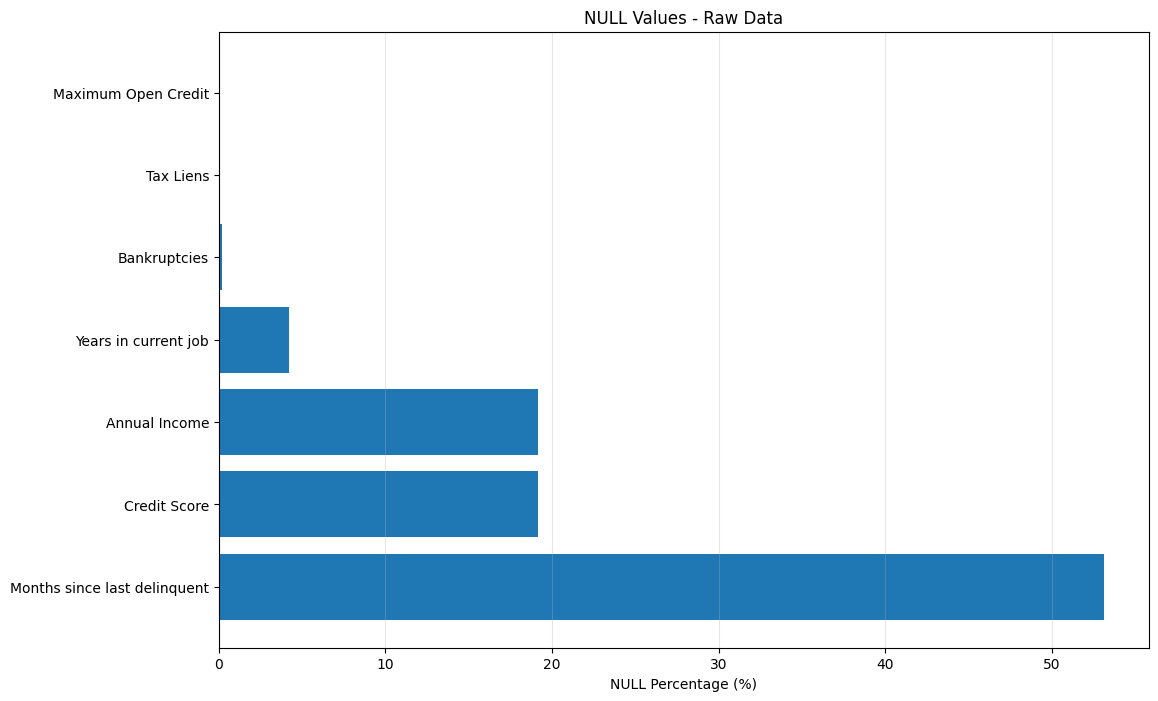

In [10]:
# NULL analysis
print("NULL Value Analysis:")
print("=" * 60)

null_analysis = df.isnull().sum().sort_values(ascending=False)
null_percentage = (null_analysis / len(df) * 100).round(2)

null_summary = pd.DataFrame({
    'Column': null_analysis.index,
    'NULL Count': null_analysis.values,
    'NULL Percentage': null_percentage.values
})

print(null_summary[null_summary['NULL Count'] > 0])

# Visualize NULL patterns
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
null_data = null_summary[null_summary['NULL Count'] > 0]
if not null_data.empty:
    ax.barh(null_data['Column'], null_data['NULL Percentage'])
    ax.set_xlabel('NULL Percentage (%)')
    ax.set_title('NULL Values - Raw Data')
    ax.grid(axis='x', alpha=0.3)
plt.show()


## Outlier Analysis


Outlier Analysis:

Current Loan Amount:
  Range: 10,802 - 99,999,999
  Outliers: 11,484 (11.48%)
  IQR: 345,290
  ⚠️  Sentinel Value (99,999,999): 11,484 records

Credit Score:
  Range: 585 - 7,510
  Outliers: 7,115 (8.80%)
  IQR: 36
  ⚠️  High Scores (>900): 4,551 records (likely x10 scale)

Annual Income:
  Range: 76,627 - 165,557,393
  Outliers: 3,809 (4.71%)
  IQR: 801,819

Monthly Debt:
  Range: 0 - 435,843
  Outliers: 3,362 (3.36%)
  IQR: 13,798


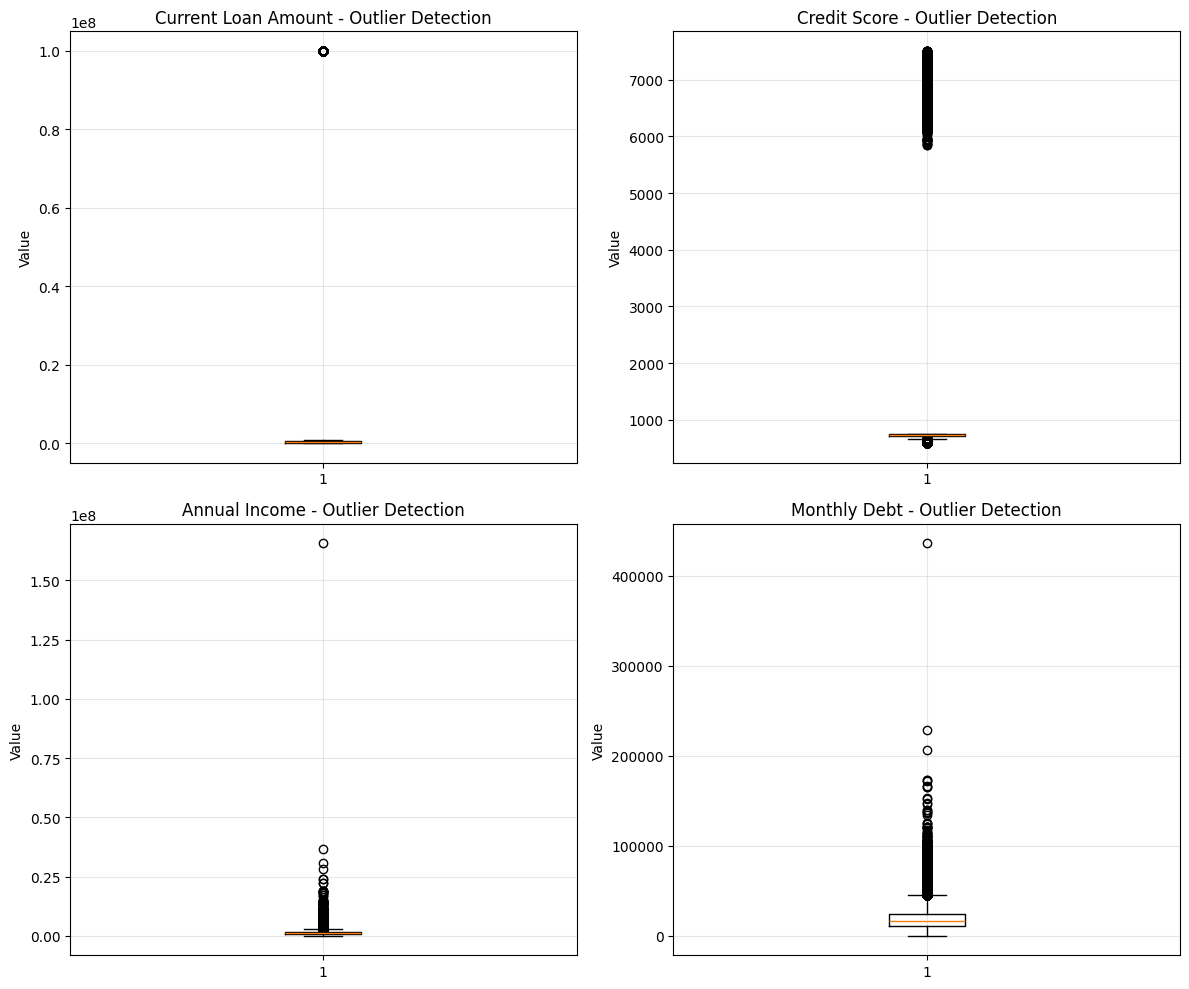

In [11]:
# Outlier analysis for key numerical fields
numerical_fields = ['Current Loan Amount', 'Credit Score', 'Annual Income', 'Monthly Debt']

print("Outlier Analysis:")
print("=" * 50)

for field in numerical_fields:
    if field in df.columns:
        data = df[field].dropna()
        if len(data) > 0:
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = data[(data < lower_bound) | (data > upper_bound)]
            
            print(f"\n{field}:")
            print(f"  Range: {data.min():,.0f} - {data.max():,.0f}")
            print(f"  Outliers: {len(outliers):,} ({len(outliers)/len(data)*100:.2f}%)")
            print(f"  IQR: {IQR:,.0f}")
            
            # Check for sentinel values
            if field == 'Current Loan Amount':
                sentinel_99999999 = (data == 99999999).sum()
                if sentinel_99999999 > 0:
                    print(f"  ⚠️  Sentinel Value (99,999,999): {sentinel_99999999:,} records")
            
            if field == 'Credit Score':
                high_scores = (data > 900).sum()
                if high_scores > 0:
                    print(f"  ⚠️  High Scores (>900): {high_scores:,} records (likely x10 scale)")

# Visualize outliers
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, field in enumerate(numerical_fields):
    if field in df.columns and i < 4:
        data = df[field].dropna()
        if len(data) > 0:
            # Box plot
            axes[i].boxplot(data, vert=True)
            axes[i].set_title(f'{field} - Outlier Detection')
            axes[i].set_ylabel('Value')
            axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Business Insights


In [12]:
# Business insights
print("Business Insights:")
print("=" * 50)

# Loan status distribution
if 'Loan Status' in df.columns:
    loan_status = df['Loan Status'].value_counts(normalize=True) * 100
    print(f"\nLoan Status Distribution:")
    for status, pct in loan_status.items():
        print(f"  {status}: {pct:.1f}%")

# Credit score insights
if 'Credit Score' in df.columns:
    credit_data = df['Credit Score'].dropna()
    print(f"\nCredit Score Insights:")
    print(f"  Average: {credit_data.mean():.1f}")
    print(f"  Median: {credit_data.median():.1f}")
    print(f"  Range: {credit_data.min()} - {credit_data.max()}")

# Purpose analysis
if 'Purpose' in df.columns:
    purpose_counts = df['Purpose'].value_counts()
    print(f"\nTop Loan Purposes:")
    for purpose, count in purpose_counts.head(5).items():
        pct = count / len(df) * 100
        print(f"  {purpose}: {count:,} ({pct:.1f}%)")


Business Insights:

Loan Status Distribution:
  Fully Paid: 77.4%
  Charged Off: 22.6%

Credit Score Insights:
  Average: 1076.5
  Median: 724.0
  Range: 585.0 - 7510.0

Top Loan Purposes:
  Debt Consolidation: 78,552 (78.6%)
  other: 6,037 (6.0%)
  Home Improvements: 5,839 (5.8%)
  Other: 3,250 (3.2%)
  Business Loan: 1,569 (1.6%)


## Data Quality Recommendations


In [13]:
print("Data Quality Recommendations:")
print("=" * 60)

print("\nCRITICAL ISSUES:")
print("1. Duplicate Records: 18% of data is duplicated")
print("   → Implement deduplication in SILVER layer")
print("   → Add unique constraints on business keys")

print("\n2. Sentinel Values: Current Loan Amount = 99,999,999")
print("   → Replace with NULL or actual values")
print("   → Add validation rules to prevent future sentinel values")

print("\n3. Credit Score Scale: Values >900 indicate x10 scale error")
print("   → Normalize credit scores to 300-850 range")
print("   → Add range validation (300-850)")

print("\nMODERATE ISSUES:")
print("4. Inconsistent Categorical Values:")
print("   → Standardize Home Ownership values")
print("   → Normalize Purpose values (case, punctuation)")
print("   → Parse Years in current job to numeric values")

print("\n5. NULL Values (Business Impact):")
print("   → Credit Score (19%): AFFECTS ANALYSIS - implement imputation")
print("   → Annual Income (19%): AFFECTS ANALYSIS - implement imputation")
print("   → Months since last delinquent (53%): POSITIVE - no action needed")

print("\nPOSITIVE INDICATORS:")
print("6. Data Completeness: Good overall structure")
print("7. No NULLs in critical business keys (Loan ID, Customer ID)")
print("8. Reasonable data distributions for most fields")

print("\nIMPLEMENTATION PRIORITY:")
print("1. HIGH: Deduplication and sentinel value handling")
print("2. HIGH: Credit score normalization")
print("3. MEDIUM: Categorical value standardization")
print("4. MEDIUM: NULL value imputation for critical fields")
print("5. LOW: Additional validation rules and monitoring")


Data Quality Recommendations:

CRITICAL ISSUES:
1. Duplicate Records: 18% of data is duplicated
   → Implement deduplication in SILVER layer
   → Add unique constraints on business keys

2. Sentinel Values: Current Loan Amount = 99,999,999
   → Replace with NULL or actual values
   → Add validation rules to prevent future sentinel values

3. Credit Score Scale: Values >900 indicate x10 scale error
   → Normalize credit scores to 300-850 range
   → Add range validation (300-850)

MODERATE ISSUES:
4. Inconsistent Categorical Values:
   → Standardize Home Ownership values
   → Normalize Purpose values (case, punctuation)
   → Parse Years in current job to numeric values

5. NULL Values (Business Impact):
   → Credit Score (19%): AFFECTS ANALYSIS - implement imputation
   → Annual Income (19%): AFFECTS ANALYSIS - implement imputation
   → Months since last delinquent (53%): POSITIVE - no action needed

POSITIVE INDICATORS:
6. Data Completeness: Good overall structure
7. No NULLs in critica